### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html

#### 1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split,  cross_val_score
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
def tpr_fpr_tnr(cnf_matrix):

        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        TNR = TN/(FP+TN)
        return TPR, FPR, TNR, TN, FN, TP, FP

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
gender = Pipeline([('selector', FeatureSelector(column='Gender')),
                   ('ohe', OHEEncoder(key='Gender'))])

gender.fit_transform(X_train).head(5)

,Gender_Female,Gender_Male
2967,1,0
700,1,0
3481,1,0
1621,0,1
800,0,1


In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

### Logistic Regression

In [9]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [10]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7615015130850086+-0.019297673514224793


In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds1 = thresholds[ix]
fscore1 = fscore[ix]
precision1 = precision[ix]
recall1 = recall[ix]

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


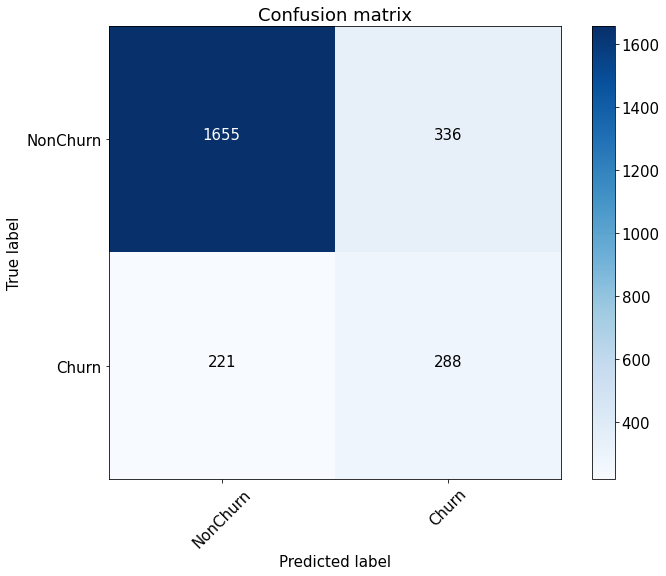

In [12]:
#нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


In [13]:
TPR, FPR, TNR, TN, FN, TP, FP= tpr_fpr_tnr(cnf_matrix)
TPR, FPR, TNR

(0.5658153241650294, 0.1687594173782019, 0.8312405826217981)

### GradientBoostingClassifier

In [14]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [15]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [16]:
#кросс-валидация
cv_scores2 = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score2 = np.mean(cv_scores2)
cv_score_std2 = np.std(cv_scores2)
print('CV score is {}+-{}'.format(cv_score2, cv_score_std2))

CV score is 0.8636126877037376+-0.016845851565090462


In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds2 = thresholds[ix] 
fscore2 = fscore[ix]
precision2 = precision[ix]
recall2 = recall[ix]

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


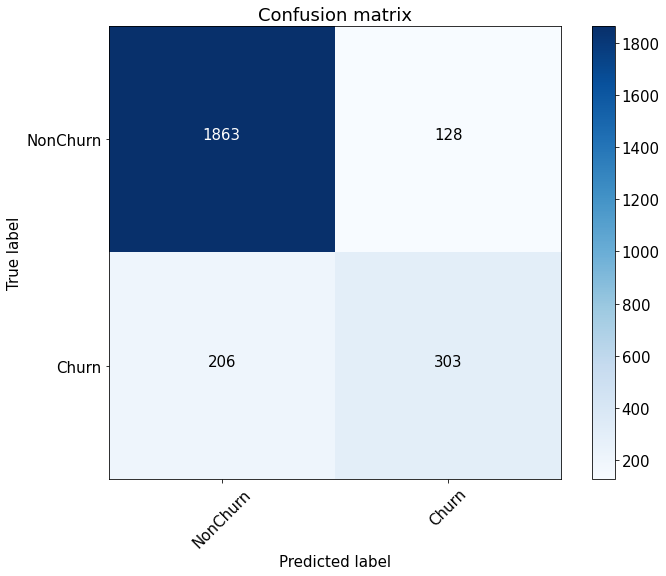

In [18]:
#нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [19]:
TPR2, FPR2, TNR2,TN2, FN2, TP2, FP2 = tpr_fpr_tnr(cnf_matrix)
TPR2, FPR2, TNR2

(0.5952848722986247, 0.06428930185836264, 0.9357106981416373)

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [20]:
metric_table = pd.DataFrame({
                      'CV_score':[cv_score, cv_score2],
                      'Best Threshold':[thresholds1, thresholds2], 
                      'F-Score':[fscore1, fscore2], 
                      'Precision':[precision1, precision2], 
                      'Recall':[recall1,recall2], 
                      'Specificity':[1-FPR, 1-FPR2],
                      'TPR': [TPR, TPR2 ],
                      'FPR': [FPR, FPR2 ],
                      'TNR': [TNR, TNR2 ],
                      'G-Means': [np.sqrt(TPR*(1-FPR)), np.sqrt(TPR2*(1-FPR2)) ] })
metric_table.index = ['LogisticRegression', 'GradientBoostingClassifier']
metric_table.round(3)

,CV_score,Best Threshold,F-Score,Precision,Recall,Specificity,TPR,FPR,TNR,G-Means
LogisticRegression,0.762,0.290,0.510,0.462,0.568,0.831,0.566,0.169,0.831,0.686
GradientBoostingClassifier,0.864,0.409,0.646,0.704,0.597,0.936,0.595,0.064,0.936,0.746


Выбираем GradientBoostingClassifie

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:  
(1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного).   (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

GradientBoostingClassifier Confusion Matrix  


In [21]:
TPR2, FPR2, TNR2, TN2, FN2, TP2, FP2 = tpr_fpr_tnr(cnf_matrix)
TN2, FN2, TP2, FP2 , TPR2

(1863, 206, 303, 128, 0.5952848722986247)

In [22]:
costs2 = TP2 + FP2  # Расходы
revenue2 = TP2 * 2  # Доходы
print(f' прибыль = {revenue2 - costs2}$')

 прибыль = 175$


### 4. (опционально)  
### Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [23]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [24]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_  , search.best_score_

({'classifier__max_depth': None,
  'classifier__max_features': 0.3,
  'classifier__min_samples_leaf': 2},
 0.858)

In [25]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=2, random_state=42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([1.12680477e-01, 3.10289974e-03, 3.19394881e-03, 3.33012682e-05,
       1.72497323e-05, 9.88415143e-01, 3.22427911e-05, 4.27340837e-04,
       5.53522966e-05, 9.95750013e-01])

In [26]:
cv_scores3 = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score3 = np.mean(cv_scores3)
cv_score_std3 = np.std(cv_scores3)
print('CV score is {}+-{}'.format(cv_score3, cv_score_std3))

CV score is 0.8465875337808534+-0.01593221082582187


In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds3 = thresholds[ix] 
fscore3 = fscore[ix]
precision3 = precision[ix]
recall3 = recall[ix]

Best Threshold=0.068916, F-Score=0.636, Precision=0.627, Recall=0.644


Confusion matrix, without normalization
[[1796  195]
 [ 182  327]]


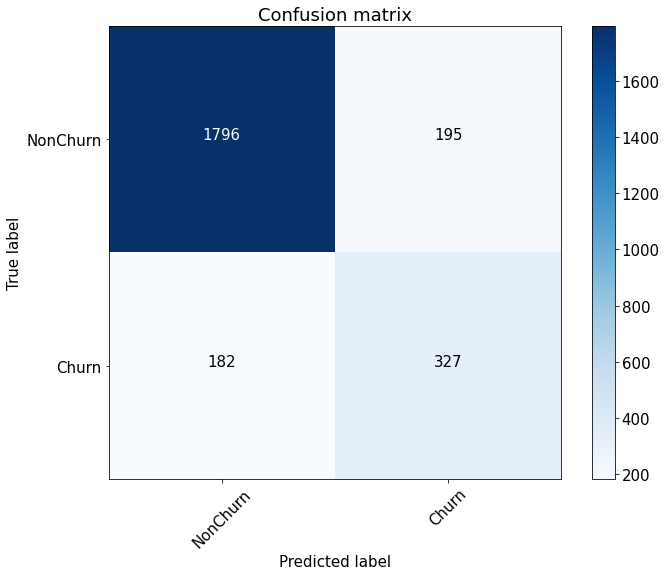

In [28]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [29]:
TPR3, FPR3, TNR3, TN3, FN3, TP3, FP3 = tpr_fpr_tnr(cnf_matrix)
TN3, FN3, TP3, FP3

(1796, 182, 327, 195)

### 5. (опционально) Еще раз провести оценку экономической эффективности

In [30]:
costs3 = TP3 + FP3  # Расходы
revenue3 = TP3 * 2  # Доходы
print(f' прибыль = {revenue3 - costs3}$')

 прибыль = 132$


In [31]:
metric_table = pd.DataFrame({
                      'CV_score':[cv_score, cv_score2, cv_score3],
                      'Best Threshold':[thresholds1, thresholds2, thresholds3], 
                      'F-Score':[fscore1, fscore2, fscore3], 
                      'Precision':[precision1, precision2, precision3], 
                      'Recall':[recall1,recall2,recall3 ], 
                      'Specificity':[1-FPR, 1-FPR2, 1-FPR3],
                      'TPR': [TPR, TPR2, TPR3],
                      'FPR': [FPR, FPR2, FPR3 ],
                      'TNR': [TNR, TNR2, TNR3 ],
                      'G-Means': [np.sqrt(TPR*(1-FPR)), np.sqrt(TPR2*(1-FPR2)),  np.sqrt(TPR3*(1-FPR3)) ],
                      'Profit': [(TP * 2)-(TP + FP),(TP2 * 2)-(TP2 + FP2),(TP3 * 2)-(TP3 + FP3) ]})
metric_table.index = ['LogisticRegression', 'GBClassifier', 'GBC_Grid_SearchCV']
metric_table.round(3)

,CV_score,Best Threshold,F-Score,Precision,Recall,Specificity,TPR,FPR,TNR,G-Means,Profit
LogisticRegression,0.762,0.290,0.510,0.462,0.568,0.831,0.566,0.169,0.831,0.686,-48
GBClassifier,0.864,0.409,0.646,0.704,0.597,0.936,0.595,0.064,0.936,0.746,175
GBC_Grid_SearchCV,0.847,0.069,0.636,0.627,0.644,0.902,0.642,0.098,0.902,0.761,132


Я выбираю GB CLassifier так как он дает более точные прогнозы а также является более прибыльным методом.